# Нейронные сети
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][HW05] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Для начала вам предстоит реализовать свой собственный backpropagation и протестировать его на реальных данных, а затем научиться обучать нейронные сети при помощи библиотеки `PyTorch` и использовать это умение для классификации классического набора данных CIFAR10.

In [3]:
import numpy as np
import copy
from sklearn.datasets import make_blobs, make_moons
from typing import List, NoReturn

### Задание 1 (3 балла)
Нейронные сети состоят из слоев, поэтому для начала понадобится реализовать их. Пока нам понадобятся только три:

`Linear` - полносвязный слой, в котором `y = Wx + b`, где `y` - выход, `x` - вход, `W` - матрица весов, а `b` - смещение. 

`ReLU` - слой, соответствующий функции активации `y = max(0, x)`.

`Softmax` - слой, соответствующий функции активации [softmax](https://ru.wikipedia.org/wiki/Softmax)


#### Методы
`forward(X)` - возвращает предсказанные для `X`. `X` может быть как вектором, так и батчем

`backward(d)` - считает градиент при помощи обратного распространения ошибки. Возвращает новое значение `d`

`update(alpha)` - обновляет веса (если необходимо) с заданой скоростью обучения

In [4]:
class Module:
    """
    Абстрактный класс. Его менять не нужно.
    """
    def forward(self, x):
        raise NotImplementedError()
    
    def backward(self, d):
        pass
        
    def update(self, alpha):
        pass

In [5]:
class Linear(Module):
    """
    Линейный полносвязный слой.
    """
    def __init__(self, in_features: int, out_features: int):
        """
        Parameters
        ----------
        in_features : int
            Размер входа.
        out_features : int 
            Размер выхода.
    
        Notes
        -----
        W и b инициализируются случайно.
        """
        self.in_features = in_features
        self.out_features = out_features
        self.W = np.random.normal(size=(in_features, out_features))
        self.b = np.random.normal(size=out_features)
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Wx + b.

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
            То есть, либо x вектор с in_features элементов,
            либо матрица размерности (batch_size, in_features).
    
        Return
        ------
        y : np.ndarray
            Выход после слоя.
            Либо вектор с out_features элементами,
            либо матрица размерности (batch_size, out_features)

        """
        
        input_size = x.shape
        if len(input_size) == 1:
            x = np.array([x])
            input_size = x.shape

        batch_size = input_size[0]
        self.batch_size = batch_size
        try:
            result = x @ self.W
        except:
            print("x:", x)
            print("W:", self.W)
        self.X = x
        
        return result + self.b
    
    def backward(self, d: np.ndarray) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        self.dLdW = self.X.T @ d
        self.dLdb = np.ones(self.batch_size) @ d
        return d @ self.W.T
        
        
    def update(self, alpha: float) -> NoReturn:
        """
        Обновляет W и b с заданной скоростью обучения.

        Parameters
        ----------
        alpha : float
            Скорость обучения.
        """
        self.W -= alpha * self.dLdW / self.batch_size
        self.b -= alpha * self.dLdb / self.batch_size
        

In [6]:
class ReLU(Module):
    """
    Слой, соответствующий функции активации ReLU.
    """
    def __init__(self):
        pass
    
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = max(0, x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        input_size = x.shape
        if len(input_size) == 1:
            x = np.array([x])
            input_size = x.shape
        
        self.Out = (x + np.absolute(x)) / 2
        
        return self.Out
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        s = np.sign(self.Out)
        
        return s * d


class Softmax(Module):
    """
    Слой, соответствующий функции активации Softmax.
    """
    def __init__(self):
        pass
        
    def forward(self, x: np.ndarray) -> np.ndarray:
        """
        Возвращает y = Softmax(x).

        Parameters
        ----------
        x : np.ndarray
            Входной вектор или батч.
    
        Return
        ------
        y : np.ndarray
            Выход после слоя (той же размерности, что и вход).

        """
        input_size = x.shape
        if len(input_size) == 1:
            x = np.array([x])
        
        x = x - np.max(x)
        self.X = x
        result = np.exp(x)
        self.Out = result / result.sum(axis=1).reshape(-1, 1)
        return self.Out
 
    def indicator(self, i, j):
        if i == j:
            return 1
        return 0
        
    def backward(self, d) -> np.ndarray:
        """
        Cчитает градиент при помощи обратного распространения ошибки.

        Parameters
        ----------
        d : np.ndarray
            Градиент.
        Return
        ------
        np.ndarray
            Новое значение градиента.
        """
        return self.Out - d


### Задание 2 (2 балла)
Теперь сделаем саму нейронную сеть.

#### Методы
`fit(X, y)` - обучает нейронную сеть заданное число эпох. В каждой эпохе необходимо использовать [cross-entropy loss](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) для обучения, а так же производить обновления не по одному элементу, а используя батчи.

`predict_proba(X)` - предсказывает вероятности классов для элементов `X`

#### Параметры конструктора
`modules` - список, состоящий из ранее реализованных модулей и описывающий слои нейронной сети. В конец необходимо добавить `Softmax`

`epochs` - количество эпох обучения

`alpha` - скорость обучения

In [7]:
class MLPClassifier:
    def __init__(self, modules: List[Module], epochs: int = 40, alpha: float = 0.01):
        """
        Parameters
        ----------
        modules : List[Module]
            Cписок, состоящий из ранее реализованных модулей и 
            описывающий слои нейронной сети. 
            В конец необходимо добавить Softmax.
        epochs : int
            Количество эпох обученияю
        alpha : float
            Cкорость обучения.
        """
        
        modules.append(Softmax())
        self.modules = modules
        self.epochs = epochs
        self.alpha = alpha
        
            
    def fit(self, X: np.ndarray, y: np.ndarray, batch_size=32) -> NoReturn:
        """
        Обучает нейронную сеть заданное число эпох. 
        В каждой эпохе необходимо использовать cross-entropy loss для обучения, 
        а так же производить обновления не по одному элементу, а используя батчи.

        Parameters
        ----------
        X : np.ndarray
            Данные для обучения.
        y : np.ndarray
            Вектор меток классов для данных.
        batch_size : int
            Размер батча.
        """
        data = np.c_[X, y]
        number_of_classes = int(np.max(y))
        number_of_classes += 1
        
        for k in range(self.epochs):
            np.random.shuffle(data)
            batches = [data[i:i + batch_size] for i in range(0, len(data), batch_size)]
            for ex_batch in batches: 
                batch_size = int(ex_batch.shape[0])
                batch = ex_batch[:,:-1]
                y_true = ex_batch[:,-1]              
                one_hot_encoding = np.zeros((batch_size, number_of_classes), dtype=int)
                
                for i in range(batch_size):
                    one_hot_encoding[i][int(y_true[i])] = 1
                           
                y_pred = self.predict(batch)
                d = self.modules[-1].backward(one_hot_encoding)
                
                for layer in self.modules[-2::-1]:
                    d = layer.backward(d)

                for layer in self.modules[:-1:2]:
                    layer.update(self.alpha)
                    
    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает вероятности классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Предсказанные вероятности классов для всех элементов X.
            Размерность (X.shape[0], n_classes)
        
        """
        for layer in self.modules:
            X = layer.forward(X)
        return X
    
    def predict(self, X) -> np.ndarray:
        """
        Предсказывает метки классов для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Данные для предсказания.
        
        Return
        ------
        np.ndarray
            Вектор предсказанных классов
        
        """
        p = self.predict_proba(X)
        return np.argmax(p, axis=1)

In [8]:
p = MLPClassifier([
    Linear(4, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)
])

X = np.random.randn(50, 4)
y = [(0 if x[0] > x[2]**2 or x[3]**3 > 0.5 else 1) for x in X]
p.fit(X, y)

### Задание 3 (2 балла)
Протестируем наше решение на синтетических данных. Необходимо подобрать гиперпараметры, при которых качество полученных классификаторов будет достаточным.

#### Оценка
Accuracy на первом датасете больше 0.85 - +1 балл

Accuracy на втором датасете больше 0.85 - +1 балл

In [9]:
%%time
X, y = make_moons(400, noise=0.075)
X_test, y_test = make_moons(400, noise=0.075)

best_acc = 0
for _ in range(3):
    p = MLPClassifier([Linear(2, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 2)])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 1.0
CPU times: user 641 ms, sys: 218 ms, total: 859 ms
Wall time: 625 ms


In [10]:
X, y = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
X_test, y_test = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5], [-2.5, 3]])
best_acc = 0
for _ in range(3):
    p = MLPClassifier([Linear(2, 64),
    ReLU(),
    Linear(64, 64),
    ReLU(),
    Linear(64, 3)])

    p.fit(X, y)
    best_acc = max(np.mean(p.predict(X_test) == y_test), best_acc)
print("Accuracy", best_acc)

Accuracy 0.975


## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2)
        self.linear1 = nn.Linear(in_features=800, out_features=10)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv3(F.relu(self.conv2(F.relu(self.conv1(x))))))
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        return x
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    y_pred = model(X)
    return F.cross_entropy(y_pred, y)

In [14]:
from tqdm import tqdm

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [15]:
def train(model, epochs=20):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in tqdm(range(epochs)):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [16]:
model = Model().to(device)
train_l, test_l = train(model)

  5%|▌         | 1/20 [00:07<02:23,  7.58s/it]

Epoch 0 | Train loss 2.071402036972046 | Test loss 1.905969922065735


 10%|█         | 2/20 [00:14<02:13,  7.42s/it]

Epoch 1 | Train loss 1.7836808391571044 | Test loss 1.691786616706848


 15%|█▌        | 3/20 [00:21<02:04,  7.35s/it]

Epoch 2 | Train loss 1.6646481427001953 | Test loss 1.63362686958313


 20%|██        | 4/20 [00:28<01:56,  7.30s/it]

Epoch 3 | Train loss 1.5982114428710938 | Test loss 1.560564730644226


 25%|██▌       | 5/20 [00:36<01:48,  7.23s/it]

Epoch 4 | Train loss 1.5350711517715454 | Test loss 1.5262776748657227


 30%|███       | 6/20 [00:43<01:41,  7.26s/it]

Epoch 5 | Train loss 1.4914640214538575 | Test loss 1.474253085899353


 35%|███▌      | 7/20 [00:50<01:33,  7.18s/it]

Epoch 6 | Train loss 1.4609044058609009 | Test loss 1.4396539644241333


 40%|████      | 8/20 [00:57<01:26,  7.19s/it]

Epoch 7 | Train loss 1.4320603653717041 | Test loss 1.4238665126800538


 45%|████▌     | 9/20 [01:04<01:19,  7.18s/it]

Epoch 8 | Train loss 1.4158088890075684 | Test loss 1.4039528779983521


 50%|█████     | 10/20 [01:11<01:11,  7.11s/it]

Epoch 9 | Train loss 1.3961679695129394 | Test loss 1.3870320775985718


 55%|█████▌    | 11/20 [01:19<01:04,  7.16s/it]

Epoch 10 | Train loss 1.3769177248001099 | Test loss 1.3743327140808106


 60%|██████    | 12/20 [01:26<00:58,  7.26s/it]

Epoch 11 | Train loss 1.3615925918960572 | Test loss 1.3665242826461792


 65%|██████▌   | 13/20 [01:33<00:50,  7.23s/it]

Epoch 12 | Train loss 1.3452918184280396 | Test loss 1.345009654045105


 70%|███████   | 14/20 [01:40<00:43,  7.17s/it]

Epoch 13 | Train loss 1.3259682950210572 | Test loss 1.3220152828216554


 75%|███████▌  | 15/20 [01:47<00:35,  7.17s/it]

Epoch 14 | Train loss 1.3133557599639893 | Test loss 1.319526417350769


 80%|████████  | 16/20 [01:55<00:28,  7.21s/it]

Epoch 15 | Train loss 1.3123601971435548 | Test loss 1.3247138076782226


 85%|████████▌ | 17/20 [02:02<00:21,  7.19s/it]

Epoch 16 | Train loss 1.2992000143432618 | Test loss 1.2906265295028687


 90%|█████████ | 18/20 [02:09<00:14,  7.19s/it]

Epoch 17 | Train loss 1.2824403424835205 | Test loss 1.2983025199890137


 95%|█████████▌| 19/20 [02:16<00:07,  7.13s/it]

Epoch 18 | Train loss 1.2676522193908693 | Test loss 1.3064449522018433


100%|██████████| 20/20 [02:23<00:00,  7.18s/it]

Epoch 19 | Train loss 1.2647935598754882 | Test loss 1.2749464544296265


Построим график функции потерь

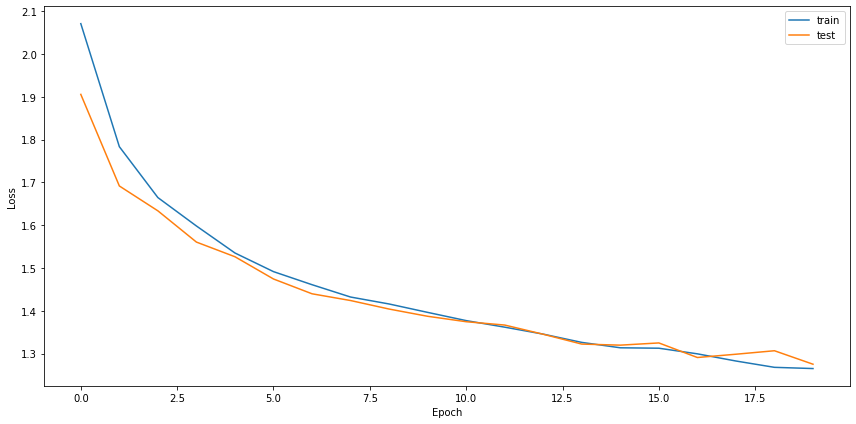

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [18]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.5454
Precision [0.55086849 0.66437008 0.51803279 0.42817294 0.48711656 0.42693191
 0.61214953 0.54444444 0.69230769 0.53515625]
Recall [0.666 0.675 0.316 0.307 0.397 0.558 0.655 0.637 0.558 0.685]
Mean Precision 0.5459550683800893
Mean Recall 0.5454000000000001
